# IS 4487 Lab 11

## Learning Objective

Use Linear Regression to predict the AQI in Utah.

## Outline

- Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

- Your target variable will be *AQI", which is the value of the air quality index

- We will focus the analysis on only the air quality in the state of Utah.  

- Note that there is a several-month lag in preparing data; you should check to see if your file has a full year of data from January to December.  If not, use the previous year.    

- The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab_11_air_quality_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [1]:
# 导入处理数据和建模所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 设置绘图风格
sns.set(style="whitegrid")

# 显示所有列
pd.set_option('display.max_columns', None)


## Import Data into Dataframe

➡️ Assignment Tasks
- Pull the latest full year of data using the "Daily AQI by County" files from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Make sure to UNZIP the file
- Import data from the air quality dataset into a dataframe
- Describe or profile the dataframe

In [3]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import zipfile # This import is no longer needed
import os

from google.colab import files

# 上传 CSV 文件
uploaded = files.upload()

# 获取上传的文件名
csv_filename = list(uploaded.keys())[0]

# 读取 CSV 文件
df = pd.read_csv(csv_filename)

# 显示前几行
print("前五行数据：")
print(df.head())

# 显示数据框的结构信息
print("\n数据结构信息：")
print(df.info())

# 描述性统计
print("\n描述性统计：")
print(df.describe())

# 检查是否包含完整一年的数据
df['Date'] = pd.to_datetime(df['Date'])
print("\n数据时间范围：")
print("最早日期：", df['Date'].min())
print("最晚日期：", df['Date'].max())

Saving daily_aqi_by_county_2023.csv to daily_aqi_by_county_2023 (1).csv
前五行数据：
  State Name county Name  State Code  County Code        Date  AQI Category  \
0    Alabama     Baldwin           1            3  2023-01-10   47     Good   
1    Alabama     Baldwin           1            3  2023-01-11   38     Good   
2    Alabama     Baldwin           1            3  2023-01-12   30     Good   
3    Alabama     Baldwin           1            3  2023-01-13   24     Good   
4    Alabama     Baldwin           1            3  2023-01-14   27     Good   

  Defining Parameter Defining Site  Number of Sites Reporting  
0              PM2.5   01-003-0010                          1  
1              PM2.5   01-003-0010                          1  
2              PM2.5   01-003-0010                          1  
3              PM2.5   01-003-0010                          1  
4              PM2.5   01-003-0010                          1  

数据结构信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325

## Prepare Data

➡️ Assignment Tasks
- Filter the data to use Utah data only
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month of year, year, and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- After filtering for Utah, remove the geographical variables that remain (county, state) since those non-numeric values can't be used.  Remove any other non-numeric variables.
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI
- Split the data 80/20 for training and testing

In [4]:
# ✅ 筛选出 Utah 的数据
utah_df = df[df['State Name'] == 'Utah'].copy()

# ✅ 创建 dummy 变量（针对 Defining Parameter）
defining_dummies = pd.get_dummies(utah_df['Defining Parameter'], prefix='Param')

# 合并 dummy 变量到原始数据中
utah_df = pd.concat([utah_df, defining_dummies], axis=1)

# ✅ 创建时间变量（年、月、季节）
utah_df['Date'] = pd.to_datetime(utah_df['Date'])
utah_df['Year'] = utah_df['Date'].dt.year
utah_df['Month'] = utah_df['Date'].dt.month

# 创建季节列
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

utah_df['Season'] = utah_df['Month'].apply(get_season)

# 将 Season 转换成 dummy 变量
season_dummies = pd.get_dummies(utah_df['Season'], prefix='Season')
utah_df = pd.concat([utah_df, season_dummies], axis=1)

# ✅ 去除空值（虽然目前看不到空值，保险起见）
utah_df = utah_df.dropna()

# ✅ 去除地理类和非数值型变量
columns_to_drop = ['State Name', 'county Name', 'State Code', 'County Code',
                   'Date', 'Category', 'Defining Parameter', 'Defining Site', 'Season']
utah_df.drop(columns=columns_to_drop, inplace=True)

# ✅ 移除极端异常值（AQI > 500 属于异常）
utah_df = utah_df[utah_df['AQI'] <= 500]

# ✅ 查看处理后的数据
print("处理后的 Utah 数据：")
print(utah_df.head())
print("\n处理后数据的列名：")
print(utah_df.columns)


处理后的 Utah 数据：
        AQI  Number of Sites Reporting  Param_NO2  Param_Ozone  Param_PM10  \
280475   35                          1      False         True       False   
280476   34                          1      False         True       False   
280477   34                          1      False         True       False   
280478   31                          1      False         True       False   
280479   27                          1      False         True       False   

        Param_PM2.5  Year  Month  Season_Fall  Season_Spring  Season_Summer  \
280475        False  2023      1        False          False          False   
280476        False  2023      1        False          False          False   
280477        False  2023      1        False          False          False   
280478        False  2023      1        False          False          False   
280479        False  2023      1        False          False          False   

        Season_Winter  
280475           T

In [5]:
# 设置目标变量 y 和特征变量 X
y = utah_df['AQI']
X = utah_df.drop(columns=['AQI'])

# 拆分为训练集和测试集（80/20）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 输出训练集/测试集的大小
print("训练集大小：", X_train.shape)
print("测试集大小：", X_test.shape)


训练集大小： (4183, 11)
测试集大小： (1046, 11)


## Create Model

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.  (for example, sklearn LinearRegression)
- Evaluate the model by displaying the R squared value  
- Visualize the correlation between the target variable and at least one of the independent variables

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 创建线性回归模型
model = LinearRegression()

# 拟合模型
model.fit(X_train, y_train)

# 用测试集预测
y_pred = model.predict(X_test)

# 计算 R² 值
r2 = r2_score(y_test, y_pred)
print("模型 R² 值：", round(r2, 4))


模型 R² 值： 0.149


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas

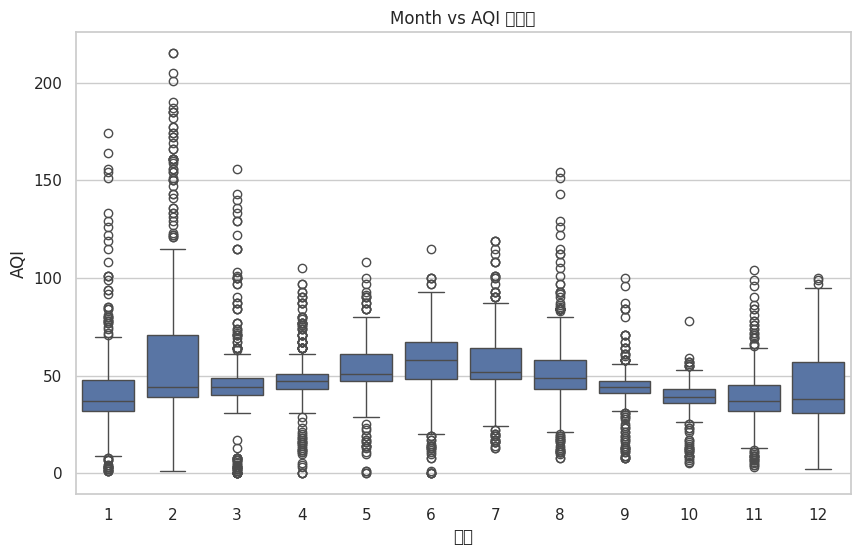

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 可视化 Month 与 AQI 的关系
plt.figure(figsize=(10, 6))
sns.boxplot(x=utah_df['Month'], y=utah_df['AQI'])
plt.title('Month vs AQI 分布图')
plt.xlabel('月份')
plt.ylabel('AQI')
plt.show()


## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in January of the upcoming year?  

In [8]:
# 构造“明年1月”的特征向量，假设预测时间为 2024 年 1 月
# 特征列顺序必须和 X_train 一致
feature_cols = X_train.columns

# 示例构造：一个站点，PM2.5 为定义参数，时间为 1 月，季节为冬季
january_features = pd.DataFrame([{
    'Number of Sites Reporting': 1,
    'Param_NO2': False,
    'Param_Ozone': False,
    'Param_PM10': False,
    'Param_PM2.5': True,
    'Year': 2024,
    'Month': 1,
    'Season_Fall': False,
    'Season_Spring': False,
    'Season_Summer': False,
    'Season_Winter': True
}])

# 确保列顺序与训练集一致
january_features = january_features[feature_cols]

# 进行预测
predicted_aqi = model.predict(january_features)[0]
print(f"预测 2024 年 1 月的平均 AQI 值为：{round(predicted_aqi, 2)}")


预测 2024 年 1 月的平均 AQI 值为：48.1


## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from several previous years using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [10]:
# 上传并读取 2022 年的数据文件（已解压为 CSV）
from google.colab import files
uploaded = files.upload()

# 假设文件为 'daily_aqi_by_county_2022.csv'
df_2022 = pd.read_csv('daily_aqi_by_county_2022.csv')

# 筛选出 Utah 数据
df_2022_ut = df_2022[df_2022['State Name'] == 'Utah'].copy()


Saving daily_aqi_by_county_2022.csv to daily_aqi_by_county_2022.csv


In [11]:
# 创建 Defining Parameter 的 dummy 变量
dp_dummies = pd.get_dummies(df_2022_ut['Defining Parameter'], prefix='Param')
df_2022_ut = pd.concat([df_2022_ut, dp_dummies], axis=1)

# 创建日期字段
df_2022_ut['Date'] = pd.to_datetime(df_2022_ut['Date'])
df_2022_ut['Year'] = df_2022_ut['Date'].dt.year
df_2022_ut['Month'] = df_2022_ut['Date'].dt.month

# 创建季节字段
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_2022_ut['Season'] = df_2022_ut['Month'].apply(get_season)
season_dummies = pd.get_dummies(df_2022_ut['Season'], prefix='Season')
df_2022_ut = pd.concat([df_2022_ut, season_dummies], axis=1)

# 清理列
drop_cols = ['State Name', 'county Name', 'State Code', 'County Code',
             'Date', 'Category', 'Defining Parameter', 'Defining Site', 'Season']
df_2022_ut.drop(columns=drop_cols, inplace=True)

# 去除极端值
df_2022_ut = df_2022_ut[df_2022_ut['AQI'] <= 500]


In [12]:
# 合并两个年份的数据
combined_df = pd.concat([utah_df, df_2022_ut], ignore_index=True)

# 检查是否需要补齐缺失列（部分 dummy 变量不一定出现在每一年中）
combined_df = combined_df.fillna(False)


In [13]:
# 设置 X 和 y
X_combined = combined_df.drop(columns=['AQI'])
y_combined = combined_df['AQI']

# 拆分训练和测试集
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# 建模
model_c = LinearRegression()
model_c.fit(X_train_c, y_train_c)

# 模型性能
r2_c = model_c.score(X_test_c, y_test_c)
print("合并模型 R² 值：", round(r2_c, 4))

# 查看 Year 的回归系数
coef_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Coefficient': model_c.coef_
})
print("\n各特征系数：")
print(coef_df[coef_df['Feature'] == 'Year'])


合并模型 R² 值： 0.1193

各特征系数：
  Feature  Coefficient
5    Year     0.863379
